In [1]:
import numpy as np
from astropy.table import Table
import thecannon as tc
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
#from mpi4py import MPI
import multiprocess as mp
from multiprocess import Pool
import os
import tqdm

## Let's start by training and testing only on giants with modest reddening (logg<3, Teff<5500K, A_v < 1)

Currently training on mock BP RP spectra from Maddie.  Ultimately, we will want to train directly on the Hermite coefficient matrices to save time.

In [2]:
#paths
table_path = '/Users/catherinemanea/Documents/BP_RP/apogee_bprp_params/apogee_bprp_params/'
spec_path = '/Users/catherinemanea/Documents/BP_RP/apogee_bprp_params/apogee_bprp_params/' #assumes spec are in directory 'apogee' inside this path
fig_path = '/Users/catherinemanea/Documents/BP_RP/apogee_bprp_params/apogee_bprp_params/'

Load in labels:

In [3]:
t = Table.read(table_path+'synth_apogee_good.fits', format='fits')
t_apogee = Table.read(table_path+'apogee_info_good_2mass_wise.fits', format='fits')
t_apogee['GAIAEDR3_PHOT_BP_MEAN_MAG_err'] = t_apogee['J_err']
t_apogee['GAIAEDR3_PHOT_RP_MEAN_MAG_err'] = t_apogee['J_err']

Load in spectra:

In [333]:
#loading in spec with max normalization
size = len(t) #adjust if you only want to play with subset of data

def read_in_data(i):
#     if i%1000 == 0:
#         print(str(np.round(100*i/size, 2))+'%', end='    \r')
    Teff = t['Teff'][i] ; logg = t['logg'][i] ; feh = t['feh'][i] ;  a = t['A_v'][i] ; s = t['SNR'][i]
    filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff),str(logg),str(feh),str(a),str(s))
    try:
        w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
        wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
       
    except:  
        try:
            formatter = "{0:.12g}"
            Teff2 = formatter.format(Teff)
            logg2 = formatter.format(logg)
            feh2 = formatter.format(feh)
            s2 = formatter.format(s)
            a2 = formatter.format(a)
            filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff2),str(logg2),str(feh2),str(a2),str(s2))
            w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
            wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
            
        except:
            try:
                formatter = "{0:.12g}"
                logg2 = formatter.format(logg)
                feh2 = formatter.format(feh)
                s2 = formatter.format(s)
                a2 = formatter.format(a)
                filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff),str(logg2),str(feh2),str(a2),str(s2))
                w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
                wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
                
            except:
                formatter = "{0:.12g}"
                Teff2 = formatter.format(Teff)
                logg2 = formatter.format(logg)
                feh2 = formatter.format(feh)
                a2 = formatter.format(a)
                s = "{0:.1f}".format(s)
                filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff2),str(logg2),str(feh2),str(a2),str(s))
                w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
                wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)

#     w = w[~np.isnan(ebp)]
#     wr = wr[~np.isnan(erp)]
    fbp = fbp[~np.isnan(ebp)]
    ebp = ebp[~np.isnan(ebp)]
    frp = frp[~np.isnan(erp)]
    erp = erp[~np.isnan(erp)]
    
    
    #add in photometry
    
    photometry_vals = list(t_apogee['GAIAEDR3_PHOT_BP_MEAN_MAG', 'GAIAEDR3_PHOT_RP_MEAN_MAG','J', 'H', 'K', 'W1', 'W2', 'W3', 'W4'][i])
    #fake bp rp errs for now
    photometry_errs = list(t_apogee['GAIAEDR3_PHOT_BP_MEAN_MAG_err', 'GAIAEDR3_PHOT_RP_MEAN_MAG_err', 'J_err', 'H_err', 'K_err', 'W1_err', 'W2_err', 'W3_err', 'W4_err'][i])
    
    f = np.concatenate([fbp,frp, photometry_vals])
    errs = np.concatenate([ebp,erp, photometry_errs])
    
    if i%1000 == 0:
        print(np.round(100*i/size, 2), '%')
    return [f, errs]



In [ ]:
import time

xs = np.zeros((len(t[:size]),906))
xerrs = np.zeros((len(t[:size]),906))

start_time = time.time()
p = Pool(os.cpu_count()-2)
results = np.array(p.map(read_in_data, range(size)))

xs = np.array(results)[:,0,:]
xerrs = np.array(results)[:,1,:]
print(time.time() - start_time, ' s')
print(xs)

[1.32594465e+02 2.58822897e+02 4.76349666e+02 8.26555754e+02
 1.35388268e+03 2.10045693e+03 3.09787683e+03 4.36131798e+03
 5.88709096e+03 7.65226284e+03 9.61707780e+03 1.17301324e+04
 1.39276585e+04 1.61364462e+04 1.82730809e+04 2.02475319e+04
 2.19688680e+04 2.33590942e+04 2.43601572e+04 2.49515760e+04
 2.51512529e+04 2.50204779e+04 2.46564369e+04 2.41793594e+04
 2.37194168e+04 2.33962884e+04 2.33020945e+04 2.34925888e+04
 2.39813519e+04 2.47398147e+04 2.57065356e+04 2.67977287e+04
 2.79218709e+04 2.89975021e+04 2.99596294e+04 3.07673100e+04
 3.14077515e+04 3.18864575e+04 3.22219741e+04 3.24355470e+04
 3.25501072e+04 3.25833614e+04 3.25417065e+04 3.24274013e+04
 3.22336440e+04 3.19546348e+04 3.15973169e+04 3.11966345e+04
 3.08216131e+04 3.05601527e+04 3.04989713e+04 3.06923706e+04
 3.11540271e+04 3.18570059e+04 3.27659531e+04 3.38518676e+04
 3.51114941e+04 3.65643851e+04 3.82477495e+04 4.02036564e+04
 4.24745133e+04 4.50991185e+04 4.80996579e+04 5.14721805e+04
 5.51654794e+04 5.907229

 6.85400009e+00 6.65899992e+00]
[2.94535044e+02 5.74175507e+02 1.05543842e+03 1.82956940e+03
 2.99373457e+03 4.63787999e+03 6.83313536e+03 9.60664460e+03
 1.29523022e+04 1.68130024e+04 2.11037358e+04 2.57033007e+04
 3.04728418e+04 3.52546046e+04 3.98679595e+04 4.41110652e+04
 4.77947454e+04 5.07475640e+04 5.28457369e+04 5.40529343e+04
 5.44066711e+04 5.40404653e+04 5.31781035e+04 5.20704216e+04
 5.09951027e+04 5.02157079e+04 4.99284019e+04 5.02498375e+04
 5.12132377e+04 5.27437579e+04 5.47213404e+04 5.69559239e+04
 5.92641500e+04 6.14677589e+04 6.34237506e+04 6.50557977e+04
 6.63302329e+04 6.72624790e+04 6.78941813e+04 6.82652142e+04
 6.84334624e+04 6.84283052e+04 6.82752833e+04 6.79654647e+04
 6.74959244e+04 6.68411241e+04 6.60205431e+04 6.51016991e+04
 6.42311983e+04 6.36061462e+04 6.34027624e+04 6.37437172e+04
 6.46493357e+04 6.60737965e+04 6.79267794e+04 7.01346256e+04
 7.26949631e+04 7.56368231e+04 7.90298617e+04 8.29616826e+04
 8.75220922e+04 9.27882689e+04 9.88107328e+04 1.05592

 1.16110001e+01 9.41399956e+00][1.95780890e+01 3.82513600e+01 7.03758240e+01 1.22327129e+02
 2.00797030e+02 3.12528442e+02 4.61697358e+02 6.51637180e+02
 8.81876861e+02 1.14978517e+03 1.44924320e+03 1.77229390e+03
 2.11004891e+03 2.45115951e+03 2.78421322e+03 3.09204379e+03
 3.36364105e+03 3.58608168e+03 3.74840400e+03 3.84890707e+03
 3.88825555e+03 3.87665209e+03 3.82973398e+03 3.76519380e+03
 3.70283070e+03 3.66290491e+03 3.65812600e+03 3.69883293e+03
 3.78728676e+03 3.91756528e+03 4.08045473e+03 4.26456684e+03
 4.45324593e+03 4.63605018e+03 4.80038053e+03 4.93949218e+03
 5.05180925e+03 5.13766795e+03 5.19984991e+03 5.24062090e+03
 5.26231419e+03 5.26653564e+03 5.25342534e+03 5.22323229e+03
 5.17632732e+03 5.11124476e+03 5.03134799e+03 4.94568647e+03
 4.86654650e+03 4.80896642e+03 4.78668796e+03 4.81147082e+03
 4.88478649e+03 5.00537639e+03 5.16491026e+03 5.35885876e+03
 5.58600972e+03 5.84511111e+03 6.14334573e+03 6.48683253e+03
 6.87916662e+03 7.33074452e+03 7.84772744e+03 8.429554

 1.05609999e+01 9.03199959e+00]
[5.14596000e-01 1.02210100e+00 1.90708400e+00 3.36876600e+00
 5.61652300e+00 8.87452300e+00 1.33363770e+01 1.91622690e+01
 2.64150860e+01 3.50845230e+01 4.50886030e+01 5.62916750e+01
 6.84488890e+01 8.12543360e+01 9.44617570e+01 1.07627819e+02
 1.20418463e+02 1.32554312e+02 1.43738764e+02 1.53765307e+02
 1.62328233e+02 1.69378134e+02 1.74986510e+02 1.79557856e+02
 1.83768636e+02 1.88623070e+02 1.95003270e+02 2.03743222e+02
 2.15110022e+02 2.29196595e+02 2.45631398e+02 2.63831440e+02
 2.83049640e+02 3.02524209e+02 3.21663869e+02 3.40139556e+02
 3.57711547e+02 3.74235629e+02 3.89619853e+02 4.03526240e+02
 4.15564514e+02 4.25271222e+02 4.32539444e+02 4.37280652e+02
 4.40090021e+02 4.42049290e+02 4.44332864e+02 4.48594414e+02
 4.55780850e+02 4.66937964e+02 4.81744048e+02 4.99538152e+02
 5.19375852e+02 5.40552673e+02 5.62999922e+02 5.87232088e+02
 6.14526566e+02 6.46411683e+02 6.84440013e+02 7.29787355e+02
 7.83788734e+02 8.47069024e+02 9.19961488e+02 1.00208

 1.00000000e-06 1.00000000e-06]

[1.86840000e-02 2.61050000e-02 3.54120000e-02 4.66490000e-02
 5.97000000e-02 7.43630000e-02 9.03110000e-02 1.07156000e-01
 1.24496000e-01 1.41938000e-01 1.59117000e-01 1.75731000e-01
 1.91486000e-01 2.06113000e-01 2.19335000e-01 2.30882000e-01
 2.40492000e-01 2.47987000e-01 2.53244000e-01 2.56302000e-01
 2.57326000e-01 2.56655000e-01 2.54781000e-01 2.52301000e-01
 2.49889000e-01 2.48185000e-01 2.47685000e-01 2.48694000e-01
 2.51267000e-01 2.55210000e-01 2.60150000e-01 2.65615000e-01
 2.71125000e-01 2.76299000e-01 2.80848000e-01 2.84606000e-01
 2.87553000e-01 2.89737000e-01 2.91260000e-01 2.92222000e-01
 2.92736000e-01 2.92889000e-01 2.92699000e-01 2.92183000e-01
 2.91309000e-01 2.90047000e-01 2.88422000e-01 2.86585000e-01
 2.84859000e-01 2.83647000e-01 2.83364000e-01 2.84259000e-01
 2.86392000e-01 2.89602000e-01 2.93705000e-01 2.98533000e-01
 3.04037000e-01 3.10263000e-01 3.17325000e-01 3.25337000e-01
 3.34397000e-01 3.44576000e-01 3.55852000e-01 3.6811

 1.49999997e-02 4.89999987e-02][5.22848300e+00 1.02647830e+01 1.91486320e+01 3.35879880e+01
 5.50331380e+01 8.58615840e+01 1.27129948e+02 1.80229625e+02
 2.45234233e+02 3.20850408e+02 4.05337645e+02 4.98962136e+02
 5.96920448e+02 6.95703291e+02 7.93631380e+02 8.84710599e+02
 9.66694410e+02 1.03480418e+03 1.08739666e+03 1.12033022e+03
 1.13660656e+03 1.13951334e+03 1.13162140e+03 1.11713594e+03
 1.10493769e+03 1.09738596e+03 1.10343548e+03 1.12046080e+03
 1.15386784e+03 1.19945568e+03 1.25463296e+03 1.31752704e+03
 1.38255140e+03 1.44450432e+03 1.50342221e+03 1.55613519e+03
 1.59812928e+03 1.63562023e+03 1.66282430e+03 1.68468288e+03
 1.70302829e+03 1.71245421e+03 1.71976959e+03 1.72199133e+03
 1.71930734e+03 1.70997132e+03 1.69650179e+03 1.68308148e+03
 1.66889747e+03 1.66409752e+03 1.67199953e+03 1.69748131e+03
 1.73778256e+03 1.79629283e+03 1.86751474e+03 1.94879801e+03
 2.04173707e+03 2.14750439e+03 2.26398597e+03 2.39655673e+03
 2.55081597e+03 2.72591747e+03 2.92337389e+03 3.150946

 1.10349998e+01 9.62600040e+00][3.01767272e+03 5.86626084e+03 1.07529698e+04 1.85755248e+04
 3.02963739e+04 4.67872289e+04 6.86764914e+04 9.62171945e+04
 1.29225267e+05 1.67106097e+05 2.08906686e+05 2.53422230e+05
 2.99251483e+05 3.44795710e+05 3.88304979e+05 4.27920859e+05
 4.61825508e+05 4.88464051e+05 5.06757540e+05 5.16386468e+05
 5.17847869e+05 5.12465754e+05 5.02285097e+05 4.89808574e+05
 4.77643115e+05 4.68214685e+05 4.63363011e+05 4.64163817e+05
 4.70834093e+05 4.82763470e+05 4.98721473e+05 5.17061297e+05
 5.36037641e+05 5.54066586e+05 5.69966709e+05 5.82999467e+05
 5.92906812e+05 5.99712581e+05 6.03617136e+05 6.04851903e+05
 6.03525203e+05 5.99717529e+05 5.93442713e+05 5.84778091e+05
 5.73872619e+05 5.61075362e+05 5.47018666e+05 5.32699193e+05
 5.19440519e+05 5.08707504e+05 5.01767897e+05 4.99373045e+05
 5.01681351e+05 5.08265953e+05 5.18571727e+05 5.32084912e+05
 5.48624693e+05 5.68311339e+05 5.91478428e+05 6.18583631e+05
 6.50175132e+05 6.86787037e+05 7.28894951e+05 7.765418

 1.01280003e+01 9.00800037e+00]
[2.63023768e+02 5.13463927e+02 9.45265290e+02 1.64010575e+03
 2.68687577e+03 4.16856798e+03 6.14793861e+03 8.65573571e+03
 1.16858167e+04 1.51907886e+04 1.90939037e+04 2.32916515e+04
 2.76571149e+04 3.20477426e+04 3.62954055e+04 4.02239618e+04
 4.36529253e+04 4.64261088e+04 4.84306478e+04 4.96217006e+04
 5.00374045e+04 4.97987769e+04 4.90956758e+04 4.81663214e+04
 4.72699244e+04 4.66401069e+04 4.64679218e+04 4.68612039e+04
 4.78488591e+04 4.93748029e+04 5.13161780e+04 5.35040670e+04
 5.57596424e+04 5.79153594e+04 5.98406129e+04 6.14609156e+04
 6.27508009e+04 6.37285151e+04 6.44412275e+04 6.49489134e+04
 6.53130065e+04 6.55683586e+04 6.57357881e+04 6.57975891e+04
 6.57170456e+04 6.54496879e+04 6.49882768e+04 6.43856650e+04
 6.37716754e+04 6.33199924e+04 6.32019181e+04 6.35249709e+04
 6.43190685e+04 6.55487285e+04 6.71525310e+04 6.90978435e+04
 7.14063101e+04 7.41336697e+04 7.73674107e+04 8.11991540e+04
 8.57042505e+04 9.09470467e+04 9.69462908e+04 1.03663

 9.63399982e+00 8.71599960e+00]


[2.04037701e+02 3.98595337e+02 7.32704125e+02 1.27073233e+03
 2.07840254e+03 3.22153847e+03 4.74539242e+03 6.67338824e+03
 9.00263307e+03 1.16863849e+04 1.46849627e+04 1.78876485e+04
 2.12194584e+04 2.45729536e+04 2.78121350e+04 3.08210738e+04
 3.34663807e+04 3.56532832e+04 3.72926369e+04 3.83675657e+04
 3.88749050e+04 3.88872300e+04 3.85236575e+04 3.79544407e+04
 3.73538415e+04 3.69181597e+04 3.68062974e+04 3.71059523e+04
 3.78758832e+04 3.90493968e+04 4.05496125e+04 4.22481430e+04
 4.40079122e+04 4.56942967e+04 4.72163685e+04 4.85007505e+04
 4.95350832e+04 5.03213184e+04 5.08823376e+04 5.12234546e+04
 5.13627203e+04 5.13009703e+04 5.10419642e+04 5.06030611e+04
 5.00154841e+04 4.93397475e+04 4.86195756e+04 4.79423257e+04
 4.73492323e+04 4.69018327e+04 4.66177822e+04 4.65068637e+04
 4.65596405e+04 4.68134595e+04 4.72820179e+04 4.80246634e+04
 4.91118526e+04 5.05987149e+04 5.25330778e+04 5.49829469e+04
 5.79703966e+04 6.15099303e+04 6.56242356e+04 7.024

 1.22749996e+01 9.23099995e+00][1.31439000e-01 1.83501000e-01 2.48749000e-01 3.27538000e-01
 4.18985000e-01 5.21439000e-01 6.33003000e-01 7.50498000e-01
 8.71494000e-01 9.92909000e-01 1.11246400e+00 1.22770200e+00
 1.33671600e+00 1.43777500e+00 1.52900700e+00 1.60828700e+00
 1.67409700e+00 1.72505300e+00 1.76031100e+00 1.78033900e+00
 1.78614600e+00 1.78005400e+00 1.76586500e+00 1.74740000e+00
 1.72921800e+00 1.71595800e+00 1.71104200e+00 1.71651100e+00
 1.73295100e+00 1.75859300e+00 1.79129400e+00 1.82744700e+00
 1.86412300e+00 1.89851700e+00 1.92847700e+00 1.95315800e+00
 1.97219400e+00 1.98600600e+00 1.99535000e+00 2.00073800e+00
 2.00321300e+00 2.00311600e+00 2.00090400e+00 1.99630100e+00
 1.98943100e+00 1.97974100e+00 1.96757000e+00 1.95380400e+00
 1.94067100e+00 1.93126700e+00 1.92819800e+00 1.93339800e+00
 1.94703600e+00 1.96838600e+00 1.99581800e+00 2.02791600e+00
 2.06461800e+00 2.10598900e+00 2.15269200e+00 2.20557700e+00
 2.26539900e+00 2.33256800e+00 2.40706300e+00 2.488384

 1.44999996e-01            nan][1.07491053e+02 2.10499053e+02 3.88573102e+02 6.76704657e+02
 1.11247971e+03 1.73248752e+03 2.56419118e+03 3.62535462e+03
 4.91288357e+03 6.41642347e+03 8.09942876e+03 9.92542349e+03
 1.18442578e+04 1.37919456e+04 1.56998019e+04 1.74887224e+04
 1.90801215e+04 2.04097307e+04 2.14244552e+04 2.20972986e+04
 2.24396799e+04 2.24976835e+04 2.23445692e+04 2.20838326e+04
 2.18349913e+04 2.16930179e+04 2.17666338e+04 2.21034149e+04
 2.27233274e+04 2.36045200e+04 2.46941867e+04 2.59161135e+04
 2.71882811e+04 2.84434020e+04 2.96094450e+04 3.06490027e+04
 3.15530088e+04 3.23160980e+04 3.29295809e+04 3.34008044e+04
 3.37119727e+04 3.38699487e+04 3.38684419e+04 3.37116784e+04
 3.34161656e+04 3.30122015e+04 3.25475852e+04 3.20987193e+04
 3.17520133e+04 3.15856818e+04 3.16569375e+04 3.20041214e+04
 3.25921734e+04 3.33978262e+04 3.43702837e+04 3.55017090e+04
 3.68073879e+04 3.83154676e+04 4.00892285e+04 4.21805546e+04
 4.46274098e+04 4.74696192e+04 5.07358474e+04 5.440329

 1.28680000e+01 9.54199982e+00][1.13799631e+03 2.21307330e+03 4.05819870e+03 7.01322545e+03
 1.14422346e+04 1.76764633e+04 2.59545267e+04 3.63759950e+04
 4.88722836e+04 6.32210177e+04 7.90615376e+04 9.59412855e+04
 1.13325796e+05 1.30610442e+05 1.47126617e+05 1.62163624e+05
 1.75015935e+05 1.85085024e+05 1.91959960e+05 1.95508352e+05
 1.95936243e+05 1.93764333e+05 1.89786236e+05 1.84963297e+05
 1.80297280e+05 1.76693736e+05 1.74842561e+05 1.75134685e+05
 1.77638748e+05 1.82117984e+05 1.88093268e+05 1.94929916e+05
 2.01950652e+05 2.08536658e+05 2.14223880e+05 2.18727442e+05
 2.21962770e+05 2.24002915e+05 2.25009998e+05 2.25203793e+05
 2.24784833e+05 2.23916575e+05 2.22683756e+05 2.21091450e+05
 2.19059949e+05 2.16490831e+05 2.13361878e+05 2.09848979e+05
 2.06375096e+05 2.03549856e+05 2.01990145e+05 2.02127217e+05
 2.04089564e+05 2.07726776e+05 2.12764759e+05 2.18981252e+05
 2.26289458e+05 2.34771120e+05 2.44613321e+05 2.56059289e+05
 2.69353699e+05 2.84722942e+05 3.02305336e+05 3.220585

 8.34700012e+00 8.20600033e+00][2.82820000e-02 3.95110000e-02 5.35210000e-02 7.05480000e-02
 9.03750000e-02 1.12801000e-01 1.37054000e-01 1.62824000e-01
 1.89416000e-01 2.16326000e-01 2.42890000e-01 2.68584000e-01
 2.93055000e-01 3.15839000e-01 3.36668000e-01 3.54718000e-01
 3.69963000e-01 3.82036000e-01 3.90563000e-01 3.95796000e-01
 3.97797000e-01 3.97187000e-01 3.94800000e-01 3.91466000e-01
 3.88184000e-01 3.86109000e-01 3.85830000e-01 3.87973000e-01
 3.92622000e-01 3.99305000e-01 4.07484000e-01 4.16598000e-01
 4.25682000e-01 4.34380000e-01 4.42034000e-01 4.48379000e-01
 4.53443000e-01 4.57274000e-01 4.60045000e-01 4.61850000e-01
 4.62800000e-01 4.62980000e-01 4.62382000e-01 4.61042000e-01
 4.59008000e-01 4.56119000e-01 4.52512000e-01 4.48644000e-01
 4.45057000e-01 4.42431000e-01 4.41369000e-01 4.42512000e-01
 4.45846000e-01 4.51354000e-01 4.58491000e-01 4.67019000e-01
 4.76848000e-01 4.87734000e-01 5.00020000e-01 5.13856000e-01
 5.29127000e-01 5.46210000e-01 5.65161000e-01 5.856990

 7.69999996e-02            nan][8.68000e-04 1.22400e-03 1.66900e-03 2.21900e-03 2.86600e-03 3.60200e-03
 4.41400e-03 5.29200e-03 6.21400e-03 7.16100e-03 8.11800e-03 9.07100e-03
 1.00030e-02 1.08960e-02 1.17510e-02 1.25430e-02 1.32660e-02 1.39190e-02
 1.44940e-02 1.49920e-02 1.54030e-02 1.57340e-02 1.59930e-02 1.62010e-02
 1.63880e-02 1.66030e-02 1.68810e-02 1.72570e-02 1.77310e-02 1.83030e-02
 1.89470e-02 1.96370e-02 2.03400e-02 2.10280e-02 2.16820e-02 2.22970e-02
 2.28650e-02 2.33870e-02 2.38630e-02 2.42860e-02 2.46450e-02 2.49300e-02
 2.51440e-02 2.52810e-02 2.53610e-02 2.54190e-02 2.54830e-02 2.56070e-02
 2.58080e-02 2.61250e-02 2.65360e-02 2.70210e-02 2.75520e-02 2.81080e-02
 2.86860e-02 2.92960e-02 2.99690e-02 3.07370e-02 3.16300e-02 3.26600e-02
 3.38470e-02 3.51860e-02 3.66690e-02 3.82690e-02 3.99640e-02 4.17170e-02
 4.34950e-02 4.52640e-02 4.70200e-02 4.87590e-02 5.05030e-02 5.22640e-02
 5.40530e-02 5.58650e-02 5.76830e-02 5.94800e-02 6.12190e-02 6.28900e-02
 6.44790e-02 6.59920

 1.00000e-06 1.00000e-06 1.00000e-06 1.00000e-06 1.00000e-06 1.00000e-06]
[7.14371454e+03 1.38485356e+04 2.53134653e+04 4.36011003e+04
 7.08916984e+04 1.09128817e+05 1.59650754e+05 2.22902858e+05
 2.98303859e+05 3.84301522e+05 4.78583095e+05 5.78265319e+05
 6.80058825e+05 7.80312994e+05 8.75056559e+05 9.60158202e+05
 1.03156829e+06 1.08590805e+06 1.12095979e+06 1.13620476e+06
 1.13304369e+06 1.11478671e+06 1.08618305e+06 1.05290186e+06
 1.02069041e+06 9.94672123e+05 9.78631004e+05 9.74667709e+05
 9.83022192e+05 1.00224190e+06 1.02956516e+06 1.06144662e+06
 1.09410660e+06 1.12419191e+06 1.14915424e+06 1.16749663e+06
 1.17877318e+06 1.18338550e+06 1.18222362e+06 1.17633802e+06
 1.16670532e+06 1.15404518e+06 1.13873052e+06 1.12077712e+06
 1.09994190e+06 1.07600672e+06 1.04927728e+06 1.02111610e+06
 9.94211699e+05 9.72246433e+05 9.58997325e+05 9.57101323e+05
 9.67346607e+05 9.88707499e+05 1.01908997e+06 1.05634418e+06
 1.09897123e+06 1.14636538e+06 1.19866705e+06 1.25655496e+06
 1.32123908

 1.11850004e+01 9.35799980e+00]

[3.95967511e+03 7.68635480e+03 1.40690732e+04 2.42691228e+04
 3.95166044e+04 6.09244508e+04 8.92739194e+04 1.24847884e+05
 1.67365662e+05 2.15993842e+05 2.69471408e+05 3.26204759e+05
 3.84351994e+05 4.41853820e+05 4.96460000e+05 5.45787179e+05
 5.87526536e+05 6.19698607e+05 6.40997242e+05 6.51055978e+05
 6.50631516e+05 6.41535744e+05 6.26463961e+05 6.08629727e+05
 5.91351179e+05 5.77601631e+05 5.69595444e+05 5.68592595e+05
 5.74770034e+05 5.87317188e+05 6.04646467e+05 6.24721121e+05
 6.45358406e+05 6.64598422e+05 6.80966775e+05 6.93577664e+05
 7.02148959e+05 7.06831840e+05 7.08040552e+05 7.06257721e+05
 7.01873809e+05 6.95137363e+05 6.86146461e+05 6.74875811e+05
 6.61261935e+05 6.45339730e+05 6.27494519e+05 6.08654571e+05
 5.90356177e+05 5.74593780e+05 5.63329410e+05 5.58017467e+05
 5.59235427e+05 5.66736890e+05 5.79724677e+05 5.97307962e+05
 6.18809032e+05 6.43900334e+05 6.72547358e+05 7.05022613e+05
 7.41882186e+05 7.83965096e+05 8.32233561e+05 8.8727

 9.82999992e+00 9.28899956e+00]



[6.60072830e+01 1.28830929e+02 2.37436056e+02 4.12700258e+02
 6.76706662e+02 1.05049163e+03 1.55109891e+03 2.18640379e+03
 2.95542821e+03 3.84562743e+03 4.83900594e+03 5.91099088e+03
 7.02802522e+03 8.15364619e+03 9.24817803e+03 1.02596028e+04
 1.11478047e+04 1.18689686e+04 1.23947376e+04 1.27118397e+04
 1.28310764e+04 1.27811391e+04 1.26159118e+04 1.23887248e+04
 1.21698103e+04 1.20228337e+04 1.19945972e+04 1.21113339e+04
 1.23848194e+04 1.27951177e+04 1.33157875e+04 1.38993760e+04
 1.45011834e+04 1.50782043e+04 1.55987059e+04 1.60408960e+04
 1.63911534e+04 1.66598134e+04 1.68552967e+04 1.69909444e+04
 1.70759421e+04 1.71159084e+04 1.71249402e+04 1.70958044e+04
 1.70253299e+04 1.69083401e+04 1.67508355e+04 1.65649455e+04
 1.63911352e+04 1.62740956e+04 1.62629165e+04 1.63821899e+04
 1.66471343e+04 1.70381662e+04 1.75423876e+04 1.81414867e+04
 1.88341186e+04 1.96324996e+04 2.05625365e+04 2.16362186e+04
 2.28861653e+04 2.43288056e+04 2.59836483e+04 2.78

 1.14809999e+01 9.55099964e+00][7.44742014e+03 1.44539263e+04 2.64562546e+04 4.56266626e+04
 7.42889010e+04 1.14514805e+05 1.67785145e+05 2.34610339e+05
 3.14475820e+05 4.05786644e+05 5.06215839e+05 6.12719232e+05
 7.21875838e+05 8.29827731e+05 9.32338467e+05 1.02496075e+06
 1.10339147e+06 1.16394852e+06 1.20417931e+06 1.22341506e+06
 1.22300814e+06 1.20633551e+06 1.17837451e+06 1.14513996e+06
 1.11284785e+06 1.08708182e+06 1.07205667e+06 1.07016739e+06
 1.08175278e+06 1.10536767e+06 1.13802007e+06 1.17590127e+06
 1.21499353e+06 1.25168888e+06 1.28320973e+06 1.30801814e+06
 1.32546346e+06 1.33579048e+06 1.33963183e+06 1.33762365e+06
 1.33029093e+06 1.31791337e+06 1.30060314e+06 1.27839892e+06
 1.25141267e+06 1.22004373e+06 1.18540482e+06 1.14959022e+06
 1.11581776e+06 1.08799401e+06 1.06981502e+06 1.06378404e+06
 1.07058550e+06 1.08926597e+06 1.11792236e+06 1.15461171e+06
 1.19795010e+06 1.24740225e+06 1.30307452e+06 1.36563122e+06
 1.43622753e+06 1.51659775e+06 1.60874522e+06 1.713791

 1.15719995e+01 8.99400043e+00][4.48000000e-02 6.27950000e-02 8.61140000e-02 1.14365000e-01
 1.45999000e-01 1.82356000e-01 2.21675000e-01 2.64045000e-01
 3.08254000e-01 3.52584000e-01 3.95984000e-01 4.39853000e-01
 4.81233000e-01 5.19253000e-01 5.54692000e-01 5.85389000e-01
 6.11943000e-01 6.33105000e-01 6.49256000e-01 6.58712000e-01
 6.63351000e-01 6.64467000e-01 6.62349000e-01 6.57847000e-01
 6.54428000e-01 6.51854000e-01 6.54130000e-01 6.58854000e-01
 6.68885000e-01 6.81939000e-01 6.97185000e-01 7.14525000e-01
 7.31993000e-01 7.47926000e-01 7.63240000e-01 7.76890000e-01
 7.86946000e-01 7.96560000e-01 8.02811000e-01 8.07963000e-01
 8.12740000e-01 8.14454000e-01 8.16302000e-01 8.16880000e-01
 8.16343000e-01 8.13880000e-01 8.10500000e-01 8.07636000e-01
 8.03878000e-01 8.02786000e-01 8.04686000e-01 8.11048000e-01
 8.20270000e-01 8.34183000e-01 8.50630000e-01 8.68743000e-01
 8.89262000e-01 9.12343000e-01 9.36522000e-01 9.63356000e-01
 9.94230000e-01 1.02786700e+00 1.06406700e+00 1.105138

            nan            nan][2.16338000e-01 3.01635000e-01 4.08373000e-01 5.36716000e-01
 6.85453000e-01 8.51821000e-01 1.03202300e+00 1.22155100e+00
 1.41565000e+00 1.60984100e+00 1.79995900e+00 1.98247100e+00
 2.15429700e+00 2.31242900e+00 2.45399800e+00 2.57613600e+00
 2.67624200e+00 2.75236300e+00 2.80340900e+00 2.82991500e+00
 2.83392400e+00 2.81915000e+00 2.79100400e+00 2.75614200e+00
 2.72167900e+00 2.69468900e+00 2.68069600e+00 2.68301200e+00
 2.70223200e+00 2.73623800e+00 2.78110000e+00 2.83177600e+00
 2.88327500e+00 2.93134500e+00 2.97311300e+00 3.00689900e+00
 3.03235800e+00 3.04970700e+00 3.05959900e+00 3.06275300e+00
 3.05938900e+00 3.04973400e+00 3.03372200e+00 3.01149500e+00
 2.98327800e+00 2.94982600e+00 2.91264400e+00 2.87427700e+00
 2.83828200e+00 2.80880700e+00 2.78958500e+00 2.78289200e+00
 2.78934800e+00 2.80756700e+00 2.83591000e+00 2.87261500e+00
 2.91691500e+00 2.96879400e+00 3.02870600e+00 3.09731900e+00
 3.17543900e+00 3.26359900e+00 3.36217300e+00 3.470313

 5.99999987e-02            nan]
0.0
[5.04480000e-02 7.04910000e-02 9.56460000e-02 1.25984000e-01
 1.61251000e-01 2.00850000e-01 2.43913000e-01 2.89409000e-01
 3.36283000e-01 3.83409000e-01 4.29852000e-01 4.74761000e-01
 5.17333000e-01 5.56893000e-01 5.92646000e-01 6.23900000e-01
 6.49948000e-01 6.70280000e-01 6.84599000e-01 6.92960000e-01
 6.95849000e-01 6.94189000e-01 6.89274000e-01 6.82716000e-01
 6.76343000e-01 6.71814000e-01 6.70580000e-01 6.73406000e-01
 6.80463000e-01 6.91228000e-01 7.04691000e-01 7.19551000e-01
 7.34564000e-01 7.48633000e-01 7.60969000e-01 7.71205000e-01
 7.79261000e-01 7.85310000e-01 7.89684000e-01 7.92778000e-01
 7.95009000e-01 7.96555000e-01 7.97576000e-01 7.97951000e-01
 7.97469000e-01 7.95841000e-01 7.93031000e-01 7.89341000e-01
 7.85572000e-01 7.82784000e-01 7.82059000e-01 7.84049000e-01
 7.88931000e-01 7.96447000e-01 8.06132000e-01 8.17711000e-01
 8.31264000e-01 8.46989000e-01 8.65265000e-01 8.86441000e-01
 9.10690000e-01 9.38134000e-01 9.68582000e-01 1.0

 2.99999993e-02            nan]


 
%

[2.21644000e-01 3.10046000e-01 4.20241000e-01 5.53534000e-01
 7.07659000e-01 8.81019000e-01 1.06910200e+00 1.26766700e+00
 1.47259000e+00 1.67744300e+00 1.88107000e+00 2.07566000e+00
 2.26066500e+00 2.43306500e+00 2.58836800e+00 2.72489100e+00
 2.83927900e+00 2.93070800e+00 2.99714800e+00 3.04025200e+00
 3.06020700e+00 3.06058500e+00 3.04615100e+00 3.02378700e+00
 2.99971800e+00 2.98216600e+00 2.97776300e+00 2.98957000e+00
 3.02080800e+00 3.06706900e+00 3.12531800e+00 3.19004400e+00
 3.25590100e+00 3.31770400e+00 3.37269400e+00 3.41813100e+00
 3.45431500e+00 3.48153100e+00 3.50100900e+00 3.51269900e+00
 3.51758800e+00 3.51559800e+00 3.50674700e+00 3.49160400e+00
 3.47113200e+00 3.44774400e+00 3.42226700e+00 3.39847600e+00
 3.37718700e+00 3.36126400e+00 3.35117900e+00 3.34737200e+00
 3.34901000e+00 3.35825000e+00 3.37485300e+00 3.40112000e+00
 3.43958300e+00 3.49142200e+00 3.55731600e+00 3.63943000e+00
 3.73700000e+00 3.84915800e+00 3.97608900e+00 

 2.84999996e-01            nan][1.34471000e-01 1.88185000e-01 2.55615000e-01 3.37369000e-01
 4.32555000e-01 5.39821000e-01 6.56626000e-01 7.80821000e-01
 9.08804000e-01 1.03877000e+00 1.16693200e+00 1.29175800e+00
 1.41121100e+00 1.52285600e+00 1.62482400e+00 1.71485600e+00
 1.79102500e+00 1.85237200e+00 1.89790700e+00 1.92744700e+00
 1.94231100e+00 1.94490000e+00 1.93827400e+00 1.92691700e+00
 1.91622300e+00 1.90971000e+00 1.91302300e+00 1.92776300e+00
 1.95462100e+00 1.99215200e+00 2.03761900e+00 2.08738000e+00
 2.13792000e+00 2.18693500e+00 2.23133100e+00 2.27000800e+00
 2.30325100e+00 2.33108300e+00 2.35308000e+00 2.36998400e+00
 2.38082200e+00 2.38637100e+00 2.38632000e+00 2.38079200e+00
 2.37035000e+00 2.35598200e+00 2.33924500e+00 2.32304800e+00
 2.31058000e+00 2.30454700e+00 2.30694800e+00 2.31973700e+00
 2.34083100e+00 2.36975400e+00 2.40396900e+00 2.44323000e+00
 2.48784500e+00 2.53812800e+00 2.59621000e+00 2.66320300e+00
 2.73932600e+00 2.82509500e+00 2.92073100e+00 3.024308

 5.37999988e-01            nan][5.85100000e-02 8.15960000e-02 1.10495000e-01 1.45254000e-01
 1.85537000e-01 2.30608000e-01 2.79433000e-01 3.30812000e-01
 3.83446000e-01 4.36124000e-01 4.87706000e-01 5.37252000e-01
 5.83901000e-01 6.26850000e-01 6.65305000e-01 6.98479000e-01
 7.25626000e-01 7.46209000e-01 7.59944000e-01 7.66932000e-01
 7.67774000e-01 7.63507000e-01 7.55629000e-01 7.45964000e-01
 7.36492000e-01 7.29095000e-01 7.25270000e-01 7.25876000e-01
 7.31046000e-01 7.40204000e-01 7.52250000e-01 7.65800000e-01
 7.79470000e-01 7.92073000e-01 8.02804000e-01 8.11197000e-01
 8.17173000e-01 8.20925000e-01 8.22763000e-01 8.23118000e-01
 8.22352000e-01 8.20765000e-01 8.18501000e-01 8.15570000e-01
 8.11813000e-01 8.07040000e-01 8.01186000e-01 7.94563000e-01
 7.87959000e-01 7.82549000e-01 7.79543000e-01 7.79806000e-01
 7.83586000e-01 7.90538000e-01 8.00062000e-01 8.11668000e-01
 8.25100000e-01 8.40423000e-01 8.57857000e-01 8.77700000e-01
 9.00194000e-01 9.25521000e-01 9.53671000e-01 9.843370

 1.89999994e-02 1.88999996e-01][2.31090000e-01 3.21755000e-01 4.35017000e-01 5.70916000e-01
 7.27985000e-01 9.03221000e-01 1.09246400e+00 1.29086100e+00
 1.49331900e+00 1.69495400e+00 1.89147700e+00 2.07914800e+00
 2.25473500e+00 2.41522200e+00 2.55764000e+00 2.67913600e+00
 2.77697000e+00 2.84917800e+00 2.89479900e+00 2.91441900e+00
 2.91035000e+00 2.88681800e+00 2.84953800e+00 2.80554900e+00
 2.76229300e+00 2.72686300e+00 2.70478000e+00 2.69930000e+00
 2.71084800e+00 2.73721700e+00 2.77427100e+00 2.81690800e+00
 2.85990900e+00 2.89896300e+00 2.93097800e+00 2.95427900e+00
 2.96850600e+00 2.97430900e+00 2.97285400e+00 2.96544100e+00
 2.95326800e+00 2.93720000e+00 2.91765100e+00 2.89456400e+00
 2.86753300e+00 2.83615600e+00 2.80070500e+00 2.76287000e+00
 2.72623600e+00 2.69594100e+00 2.67751300e+00 2.67486600e+00
 2.68914200e+00 2.71867300e+00 2.76012800e+00 2.81012700e+00
 2.86626100e+00 2.92741200e+00 2.99345600e+00 3.06488400e+00
 3.14277500e+00 3.22862400e+00 3.32382600e+00 3.428806

 9.70000029e-02            nan]

[1.96148000e-01 2.73283000e-01 3.69732000e-01 4.85605000e-01
 6.19637000e-01 7.69385000e-01 9.31350000e-01 1.10138600e+00
 1.27521800e+00 1.44866900e+00 1.61809700e+00 1.78030300e+00
 1.93247400e+00 2.07199100e+00 2.19629900e+00 2.30281800e+00
 2.38925200e+00 2.45379900e+00 2.49561700e+00 2.51511400e+00
 2.51429700e+00 2.49666000e+00 2.46716200e+00 2.43178700e+00
 2.39701200e+00 2.36899000e+00 2.35250600e+00 2.35043700e+00
 2.36317600e+00 2.38883000e+00 2.42380300e+00 2.46371700e+00
 2.50408500e+00 2.54113500e+00 2.57224200e+00 2.59594600e+00
 2.61194400e+00 2.62063900e+00 2.62287300e+00 2.61957300e+00
 2.61143200e+00 2.59886500e+00 2.58199900e+00 2.56070500e+00
 2.53475600e+00 2.50405100e+00 2.46918600e+00 2.43184100e+00
 2.39499700e+00 2.36281200e+00 2.33953700e+00 2.32848800e+00
 2.33101900e+00 2.34660500e+00 2.37334300e+00 2.40906900e+00
 2.45204000e+00 2.50126300e+00 2.55628500e+00 2.61727200e+00
 2.68482600e+00 2.75992100e+00 2.84361400e+00 2.9361

 3.79999988e-02 4.88000005e-01]
[8.33740000e-02 1.16416000e-01 1.58057000e-01 2.08455000e-01
 2.66907000e-01 3.32465000e-01 4.03991000e-01 4.79640000e-01
 5.57683000e-01 6.36072000e-01 7.13457000e-01 7.88583000e-01
 8.59870000e-01 9.26163000e-01 9.86483000e-01 1.03892900e+00
 1.08299200e+00 1.11747100e+00 1.14197300e+00 1.15646600e+00
 1.16189000e+00 1.15959300e+00 1.15221100e+00 1.14172400e+00
 1.13150900e+00 1.12466700e+00 1.12339200e+00 1.12880000e+00
 1.14156100e+00 1.16026900e+00 1.18370000e+00 1.20932100e+00
 1.23518600e+00 1.25949100e+00 1.28110200e+00 1.29922400e+00
 1.31321200e+00 1.32389700e+00 1.33164000e+00 1.33705800e+00
 1.34043800e+00 1.34188100e+00 1.34231200e+00 1.34118000e+00
 1.33841200e+00 1.33377200e+00 1.32761000e+00 1.32016600e+00
 1.31323600e+00 1.30850800e+00 1.30810200e+00 1.31278000e+00
 1.32341700e+00 1.33881000e+00 1.35855100e+00 1.38159000e+00
 1.40770600e+00 1.43719400e+00 1.47098100e+00 1.50879100e+00
 1.55174600e+00 1.59984200e+00 1.65347100e+00 1.71139

Define subset of data for training and testing (uncomment relevant cell):

In [306]:
def get_pixels():
    i = len(t)-1
#     if i%1000 == 0:
#         print(str(np.round(100*i/size, 2))+'%', end='    \r')
    Teff = t['Teff'][i] ; logg = t['logg'][i] ; feh = t['feh'][i] ;  a = t['A_v'][i] ; s = t['SNR'][i]
    filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff),str(logg),str(feh),str(a),str(s))
    try:
        w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
        wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
       
    except:  
        try:
            formatter = "{0:.12g}"
            Teff2 = formatter.format(Teff)
            logg2 = formatter.format(logg)
            feh2 = formatter.format(feh)
            s2 = formatter.format(s)
            a2 = formatter.format(a)
            filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff2),str(logg2),str(feh2),str(a2),str(s2))
            w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
            wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
            
        except:
            try:
                formatter = "{0:.12g}"
                logg2 = formatter.format(logg)
                feh2 = formatter.format(feh)
                s2 = formatter.format(s)
                a2 = formatter.format(a)
                filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff),str(logg2),str(feh2),str(a2),str(s2))
                w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
                wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
                
            except:
                formatter = "{0:.12g}"
                Teff2 = formatter.format(Teff)
                logg2 = formatter.format(logg)
                feh2 = formatter.format(feh)
                a2 = formatter.format(a)
                s = "{0:.1f}".format(s)
                filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff2),str(logg2),str(feh2),str(a2),str(s))
                w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
                wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)

    w = w[~np.isnan(ebp)]
    wr = wr[~np.isnan(erp)]
    
    wf_intermed = np.concatenate([w,wr])
    photometry_slots = np.arange(1081., 1090., 1.) #insert 9 slots for photometry
    wf = np.concatenate([wf_intermed,photometry_slots])
    return wf

wf = get_pixels()

In [320]:
# # **Giants**

subset = np.where((t['Teff'] < 5500) & (t['logg'] < 3) & (t['A_v'] < 1) & (t['A_v'] > 0))
t_subset = t[subset]
xs_subset = xs[subset]
xerrs_subset = xerrs[subset]

In [283]:
# # **Giants and Less Restrictive A_v

# subset = np.where((t['Teff'] < 5500) & (t['logg'] < 3) & (t['A_v'] < 3) & (t['A_v'] > 0) &  (t_apogee['W3']>1) & (t_apogee['W4']>1))
# t_subset = t[subset]
# xs_subset = xs[subset]
# xerrs_subset = xerrs[subset]





In [284]:
# # **DWARFS**

# subset = np.where((t['Teff'] < 6500) & (t['Teff'] > 4500) & (t['logg'] > 4) & (t['A_v'] < 1) & (t['A_v'] > 0))
# t_subset = t[subset]
# xs_subset = xs[subset]
# xerrs_subset = xerrs[subset]

In [285]:
# **Dwarfs+Giants**
# subset = np.where((t['Teff'] < 6500) & (t['A_v'] < 1) & (t['A_v'] > 0))
# t_subset = t[subset]
# xs_subset = xs[subset]
# xerrs_subset = xerrs[subset]

Normalize data according to desired scheme (max, min-max, deviation from mean, etc.)

In [321]:
# min max norm of each pixel

# for i in range(xs_subset.shape[1]):
#     xs_subset[:,i] = (xs_subset[:,i] - np.nanmin(xs_subset[:,i])) / (np.nanmax(xs_subset[:,i]) - np.nanmin(xs_subset[:,i]))
#     xerrs_subset[:,i] = 1/np.sqrt(xerrs_subset[:,i]/(np.nanmax(xs_subset[:,i]) - np.nanmin(xs_subset[:,i])))


# mean of each pixel norm

# for i in range(xs_subset.shape[1]):
#     xs_subset[:,i] = xs_subset[:,i] / np.nanmean(xs_subset[:,i])
#     xerrs_subset[:,i] = 1/np.sqrt(xerrs_subset[:,i]/np.nanmean(xs_subset[:,i]))
    
# max norm of each spectrum

for i in range(xs_subset.shape[0]):
    xs_subset[i,:] = xs_subset[i,:] / np.nanmax(xs_subset[i,:])
    xerrs_subset[i,:] = 1/np.sqrt(xerrs_subset[i,:] / np.nanmax(xs_subset[i,:]))
xs_subset.shape[0]

Plot some spectra just to see what they look like:

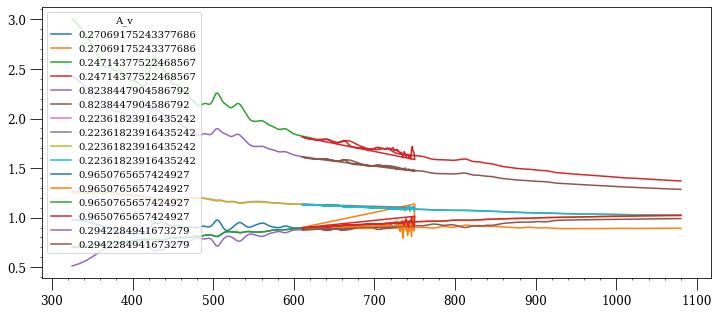

In [322]:
%matplotlib inline
teffs = t_subset['Teff']
loggs = t_subset['logg']
fehs = t_subset['feh']
avs = t_subset['A_v']
snrs = t_subset['SNR']

xs_smooth = xs_subset[i]


#remove overlap if desired
lo = 310
up = 450
end = -9
#if you don't want to remove overlap:
# lo = 310
# up = 310
# end = -9

#plot a few spectra
plt.figure(figsize=(12,5))
N=1
for i in range(8):
    plt.plot(wf[:lo], xs_subset[i][:lo], label=t_subset['A_v'][i])
    plt.plot(wf[up:end], xs_subset[i][up:end], label=t_subset['A_v'][i])
plt.legend(title="A_v")
plt.show()

wf_clean = np.concatenate([wf[:lo], wf[up:end]])

xs_subset_clean = np.zeros((len(xs_subset),len(wf_clean)))
xs_subset_clean[:,:lo] = xs_subset[:,:lo]
xs_subset_clean[:,lo:] = xs_subset[:,up:end]
xerrs_subset_clean = np.zeros((len(xs_subset),len(wf_clean)))
xerrs_subset_clean[:,:lo] = xerrs_subset[:,:lo]
xerrs_subset_clean[:,lo:] = xerrs_subset[:,up:end]

Separate training and testing sets, reassign NaN and inf values:

In [328]:
#making training and testing sets
# train_inds = np.random.choice(range(len(t)),int(.6*len(t)),replace=False)
# test_inds = np.array(list(set(range(len(t)))- set(train_inds)),dtype='int')
print(len(t), len(t[subset]))

np.random.seed(777) # For reproducibility.
q = np.random.randint(0, 10, len(t_subset)) % 10
validate_set = np.where((q<=2))[0]
train_set = np.where((q>2))[0]
train_inds = train_set
test_inds = validate_set

train_xs = xs_subset[train_inds]
train_errs = xerrs_subset[train_inds]
bad = np.where(np.isnan(train_xs))
train_xs[bad] = 0.0000001
bad = np.where(np.isnan(train_errs))
train_errs[bad] = 0.0000001
bad = np.where(train_xs==np.inf)
train_xs[bad] = 1e6
bad = np.where(train_errs==np.inf)
train_errs[bad] = 1e6

test_xs = xs_subset[test_inds]
test_errs = xerrs_subset[test_inds]
bad = np.where(np.isnan(test_xs))
test_xs[bad] = 0.0000001
bad = np.where(np.isnan(test_errs))
test_errs[bad] = 0.0000001
bad = np.where(test_xs==np.inf)
test_xs[bad] = 1e6
bad = np.where(test_errs==np.inf)
test_errs[bad] = 1e6

train_t = t_subset[train_inds]
test_t = t_subset[test_inds]

print(len(train_t), len(test_t))

59966 8187
5714 2473


Specify vectorizer, set up and train the model:

In [330]:
# # Specify the vectorizer.
# vectorizer = tc.vectorizer.PolynomialVectorizer(("Teff", "logg", "feh", "A_v"), 2)
# # set up model
# model = tc.CannonModel(train_t, train_xs, train_errs,
#                        vectorizer=vectorizer, dispersion=wf)


vectorizer = tc.vectorizer.PolynomialVectorizer(("Teff", "logg", "feh", "A_v"), 2)

model = tc.CannonModel(train_t, train_xs, train_errs,
    dispersion=wf, vectorizer=vectorizer)
# # No regularization.
model.regularization = 0

# Train the model!
model.train()


2022-06-07 11:28:56,058 [INFO] Training 4-label CannonModel with 5714 stars and 906 pixels/star
stty: 2022-06-07 11:28:56,145 [DEBUG] Couldn't get screen size. Progressbar may look odd.


[====                                                                                                ]   5% (44/906)                          

stdin isn't a terminal


[====================================================================================================] 100% (2s)                               


(array([[ 0.91057274,  1.84190427,  0.40838874, ..., -0.57389252,
          0.4989504 ,  0.86408181],
        [ 0.9108949 ,  1.83765374,  0.40604319, ..., -0.56847712,
          0.49112807,  0.8624239 ],
        [ 0.91122239,  1.83321426,  0.40361941, ..., -0.56291305,
          0.48303625,  0.86072275],
        ...,
        [ 0.96786411, -0.05082439,  0.20658787, ..., -0.21585459,
          0.14950273,  0.0997068 ],
        [ 0.93118027, -0.05506979,  0.20414679, ..., -0.22019989,
          0.20645442,  0.09541139],
        [ 1.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        

Test the model:

In [331]:
#infer for train
test_labels, cov, metadata = model.test(test_xs, test_errs)


#fig_comparison = tc.plot.one_to_one(model, test_labels, latex_label_names=[r"T_{\rm eff}",r"\log{g}",r"[{\rm Fe}/{\rm H}]",r"{\rm A_V}"])
#fig_comparison.savefig(fig_path+"one-to-one.png", dpi=300)

stty: stdin isn't a terminal
2022-06-07 11:28:59,025 [DEBUG] Couldn't get screen size. Progressbar may look odd.
2022-06-07 11:28:59,027 [INFO] Running test step on 2473 spectra


[=======================================================================================================] 100% (74s)                                


Plot difference between true and inferred values:

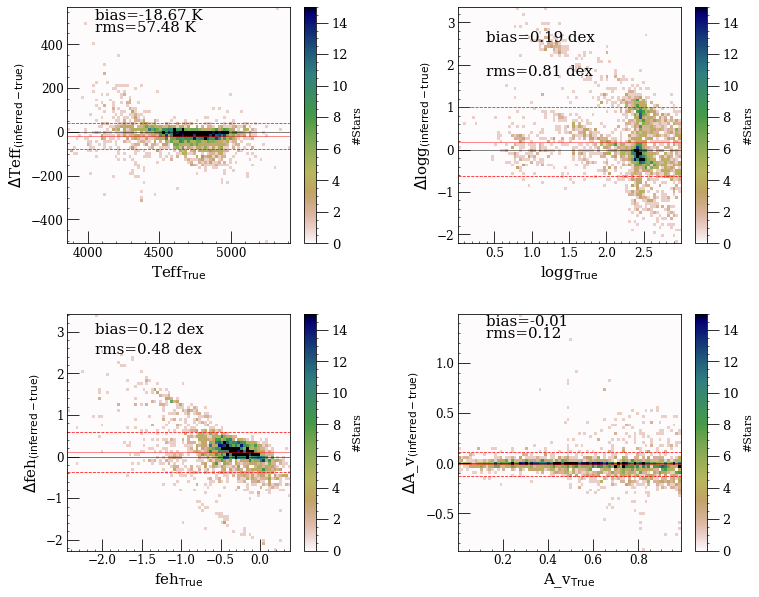

In [332]:
%matplotlib inline
font = {'family' : 'serif',
        'weight' : 'regular',
        'size'   : 11}

import matplotlib
fig, axs = plt.subplots(2,2,figsize=(12,10))
fig.subplots_adjust(hspace=0.3, wspace=0.4)
plt.rc('font', **font)
plt.rcParams['xtick.major.size'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.major.size'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["xtick.minor.visible"] =  True

    
unit = ['K', 'dex', 'dex', '']
for i, param in enumerate(['Teff', 'logg', 'feh', 'A_v']):
    ax = np.ravel(axs)[i]
    h = ax.hist2d(t_subset[param][test_inds],test_labels[:,i] - t_subset[param][test_inds], bins=80,  cmap='gist_earth_r', vmin=0, vmax=15)
    ax.axhline(y=0, c='k', alpha=.99, lw=.5)
    bias = np.round(np.mean(test_labels[:,i] - t_subset[param][test_inds]), 2)
    rms = np.round(np.std(test_labels[:,i] - t_subset[param][test_inds]), 2)
    ax.axhline(y=bias, c='r', alpha=.9, lw=.5)
    ax.axhline(y=bias+rms, c='r', alpha=.9, lw=.8, ls='--')
    ax.axhline(y=bias-rms, c='r', alpha=.9, lw=.8, ls='--')
    offset = (np.max(t_subset[param][test_inds]) - np.min(t_subset[param][test_inds]))/8
    ax.text(offset+np.min(t_subset[param][test_inds]), np.max(test_labels[:,i] - t_subset[param][test_inds])-rms, "bias={a} {b}".format(a=bias, b=unit[i]), fontsize=15)
    ax.text(offset+np.min(t_subset[param][test_inds]), np.max(test_labels[:,i] - t_subset[param][test_inds])-(2*rms), "rms={a} {b}".format(a=rms, b=unit[i]), fontsize=15)
    #ax.text(0.1, 0.8, "rms={}".format(rms))
    cbar = fig.colorbar(h[3], ax=ax, label='#Stars')
    cbar.ax.tick_params(labelsize=13) 
    #ax.set_title(param)
    ax.set_xlabel(param+r"$\rm _{{}True{}}$", fontsize=15)
    ax.set_ylabel(r"$\rm \Delta$"+param+r"$\rm _{(inferred - true)}$", fontsize=15)
    ax.tick_params(axis="both", which='both', direction="in")
#plt.savefig("Diagnostic_Figs/inferred_vs_true_giantsAv3_hist2d_wise2mass.pdf")



# Ignore below

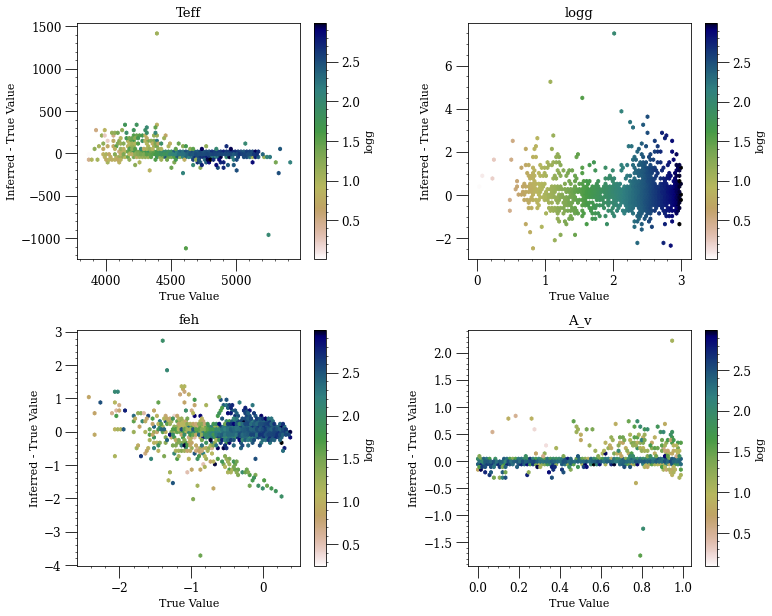

In [267]:
fig, axs = plt.subplots(2,2,figsize=(12,10))
fig.subplots_adjust(hspace=0.3, wspace=0.4)
for i, param in enumerate(['Teff', 'logg', 'feh', 'A_v']):
    ax = np.ravel(axs)[i]
    h = ax.hexbin(t_subset[param][test_inds],test_labels[:,i] - t_subset[param][test_inds], gridsize=70, C=t_subset['logg'][test_inds], cmap='gist_earth_r')
    fig.colorbar(h, ax=ax, label='logg')
    ax.set_title(param)
    ax.set_xlabel("True Value")
    ax.set_ylabel("Inferred - True Value")
#plt.savefig("Diagnostic_Figs/inferred_vs_true_giants_colorlogg.pdf")

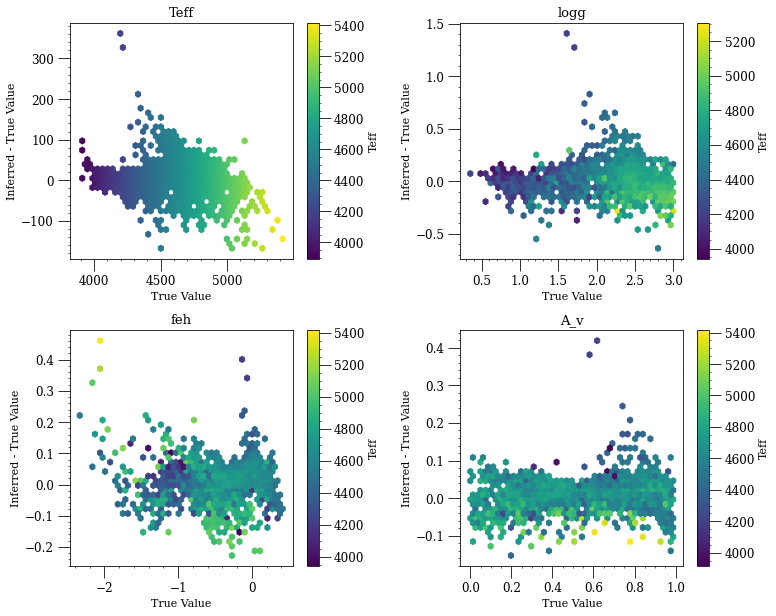

In [246]:
fig, axs = p.subplots(2,2,figsize=(12,10))
fig.subplots_adjust(hspace=0.3, wspace=0.4)
for i, param in enumerate(['Teff', 'logg', 'feh', 'A_v']):
    ax = np.ravel(axs)[i]
    h = ax.hexbin(t_subset[param][test_inds],test_labels[:,i] - t_subset[param][test_inds], gridsize=40, C=t_subset['Teff'][test_inds])
    fig.colorbar(h, ax=ax, label='Teff')
    ax.set_title(param)
    ax.set_xlabel("True Value")
    ax.set_ylabel("Inferred - True Value")
p.savefig("Diagnostic_Figs/inferred_vs_true_giants_colorTeff.pdf")

Histograms of inferred and true values

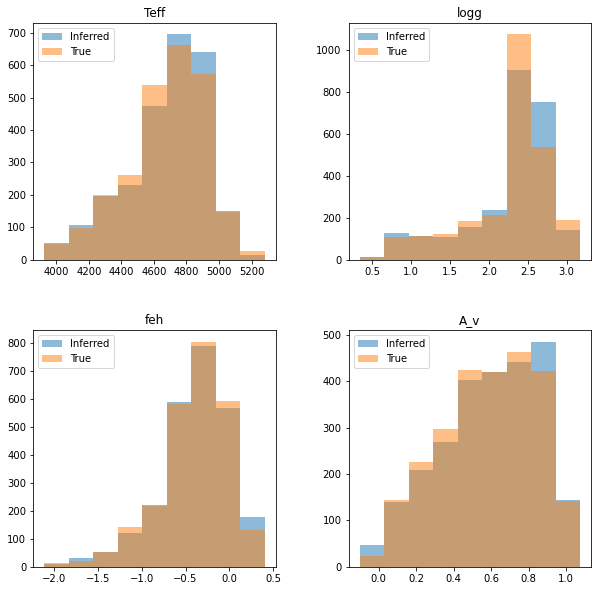

In [82]:
fig, axs = p.subplots(2,2,figsize=(10,10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i, param in enumerate(['Teff', 'logg', 'feh', 'A_v']):
    ax = np.ravel(axs)[i]
    ax.hist(test_labels[:,i], alpha=.5, label='Inferred', bins=np.linspace(np.min(test_labels[:,i]), np.max(test_labels[:,i]), 10))
    ax.hist(t_subset[param][test_inds], alpha=.5, label='True', bins=np.linspace(np.min(test_labels[:,i]), np.max(test_labels[:,i]), 10))
    ax.set_title(param)
    ax.legend()

In [22]:
print(np.mean(test_labels[:,0]))
print(np.mean(np.abs(test_labels[:,0]-t_subset['Teff'][test_inds])))
print(np.mean(np.abs(test_labels[:,1]-t_subset['logg'][test_inds])))
print(np.mean(t_subset['Teff'][test_inds]))

4713.514115503945
133.1570589247056
0.23250657097173905
4673.8448497928375


In [14]:
print(np.min(t_subset['Teff'][test_inds]), np.max(t_subset['Teff'][test_inds]))
print(np.min(t_subset['Teff'][train_inds]), np.max(t_subset['Teff'][train_inds]))

4500.07275390625 6499.94677734375
4500.07666015625 6499.4990234375


In [425]:
t = Table.read(table_path+'synth_apogee_0.fits')
t = t[t['synth']]
t_apogee = Table.read(table_path+'apogee_good_0.fits')
t_apogee_reordered = t_apogee

goods = []
for i in range(len(t)):
    if i%1000 == 0:
        print(i)
    spot = np.where((np.round(t_apogee['TEFF'], 2) == np.round(t['Teff'][i], 2)) & (np.round(t_apogee['LOGG'], 2) == np.round(t['logg'][i], 2)) & (np.round(t_apogee['M_H'], 3) == np.round(t['feh'][i], 3)) & (np.round(t_apogee['SNR'], 3) == np.round(t['SNR'][i], 3)))
    if len(spot[0]) == 1:
        spot = spot[0][0]
        #print(t['Teff'][i], t_apogee['TEFF'][spot])
        t_apogee_reordered[i] = t_apogee[spot]
        #print(t_apogee_reordered['TEFF'][i])
        goods.append(i)

print(len(goods))

t[goods].write(table_path+'synth_apogee_good.fits', format='fits', overwrite=True)
t_apogee_reordered[goods].write(table_path+'apogee_info_good.fits', format='fits', overwrite=True)
#np.round(t['Teff'][5], 2), np.round(t_apogee['TEFF'][5], 2)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
59966


In [541]:
t_apogee = Table.read(table_path+'apogee_info_good.fits')
t_apogee_2mass_wise = Table.read(table_path+'apogee_2mass_wise.fits')

t_apogee['J'], t_apogee['H'], t_apogee['K'] = np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee))
t_apogee['W1'], t_apogee['W2'], t_apogee['W3'], t_apogee['W4'] = np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee))

t_apogee['J_err'], t_apogee['H_err'], t_apogee['K_err'] = np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee))
t_apogee['W1_err'], t_apogee['W2_err'], t_apogee['W3_err'], t_apogee['W4_err'] = np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee))


#t_apogee_2mass_wise['W3mag'][(t_apogee_2mass_wise['W3mag'] == np.empty).mask]

for i, ID in enumerate(t_apogee['APOGEE_ID'][:]):
    if i % 1000 == 0:
        print(np.round(100 * ind/len(t_apogee), 2))
    if ID in t_apogee_2mass_wise['APOGEE_ID']:
        spot = np.where(t_apogee_2mass_wise['APOGEE_ID'] == ID)
        if (spot[0].size>0):
            if (spot[0].size==1):
                if (t_apogee_2mass_wise['W3mag'][spot] != np.empty) & (t_apogee_2mass_wise['W4mag'][spot] != np.empty):
                    t_apogee['J'][i] = t_apogee_2mass_wise['Jmag'][spot]
                    t_apogee['H'][i] = t_apogee_2mass_wise['Hmag'][spot]
                    t_apogee['K'][i] = t_apogee_2mass_wise['Kmag'][spot]
                    t_apogee['W1'][i] = t_apogee_2mass_wise['W1mag'][spot]
                    t_apogee['W2'][i] = t_apogee_2mass_wise['W2mag'][spot]
                    t_apogee['W3'][i] = t_apogee_2mass_wise['W3mag'][spot]
                    t_apogee['W4'][i] = t_apogee_2mass_wise['W4mag'][spot]
                    t_apogee['J_err'][i] = t_apogee_2mass_wise['e_Jmag'][spot]
                    t_apogee['H_err'][i] = t_apogee_2mass_wise['e_Hmag'][spot]
                    t_apogee['K_err'][i] = t_apogee_2mass_wise['e_Kmag'][spot]
                    t_apogee['W1_err'][i] = t_apogee_2mass_wise['e_W1mag'][spot]
                    t_apogee['W2_err'][i] = t_apogee_2mass_wise['e_W2mag'][spot]
                    t_apogee['W3_err'][i] = t_apogee_2mass_wise['e_W3mag'][spot]
                    t_apogee['W4_err'][i] = t_apogee_2mass_wise['e_W4mag'][spot]
            else:
                spot = spot[0][0]
                t_apogee['J'][i] = t_apogee_2mass_wise['Jmag'][spot]
                t_apogee['H'][i] = t_apogee_2mass_wise['Hmag'][spot]
                t_apogee['K'][i] = t_apogee_2mass_wise['Kmag'][spot]
                t_apogee['W1'][i] = t_apogee_2mass_wise['W1mag'][spot]
                t_apogee['W2'][i] = t_apogee_2mass_wise['W2mag'][spot]
                t_apogee['W3'][i] = t_apogee_2mass_wise['W3mag'][spot]
                t_apogee['W4'][i] = t_apogee_2mass_wise['W4mag'][spot]
                t_apogee['J_err'][i] = t_apogee_2mass_wise['e_Jmag'][spot]
                t_apogee['H_err'][i] = t_apogee_2mass_wise['e_Hmag'][spot]
                t_apogee['K_err'][i] = t_apogee_2mass_wise['e_Kmag'][spot]
                t_apogee['W1_err'][i] = t_apogee_2mass_wise['e_W1mag'][spot]
                t_apogee['W2_err'][i] = t_apogee_2mass_wise['e_W2mag'][spot]
                t_apogee['W3_err'][i] = t_apogee_2mass_wise['e_W3mag'][spot]
                t_apogee['W4_err'][i] = t_apogee_2mass_wise['e_W4mag'][spot]

t_apogee

FILE,APOGEE_ID,TARGET_ID,APSTAR_ID,ASPCAP_ID,TELESCOPE,LOCATION_ID,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,H,H_ERR,K,K_ERR,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,TARG_PMRA,TARG_PMDEC,TARG_PM_SRC,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,APOGEE_TARGET1,APOGEE_TARGET2,APOGEE2_TARGET1,APOGEE2_TARGET2,APOGEE2_TARGET3,APOGEE2_TARGET4,TARGFLAGS,SURVEY,PROGRAMNAME,NVISITS,SNR,SNREV,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,RV_TEFF,RV_LOGG,RV_FEH,RV_ALPHA,RV_CARB,RV_CHI2,RV_CCFWHM,RV_AUTOFWHM,RV_FLAG,N_COMPONENTS,MEANFIB,SIGFIB,MIN_H,MAX_H,MIN_JK,MAX_JK,GAIAEDR3_SOURCE_ID,GAIAEDR3_PARALLAX,GAIAEDR3_PARALLAX_ERROR,GAIAEDR3_PMRA,GAIAEDR3_PMRA_ERROR,GAIAEDR3_PMDEC,GAIAEDR3_PMDEC_ERROR,GAIAEDR3_PHOT_G_MEAN_MAG,GAIAEDR3_PHOT_BP_MEAN_MAG,GAIAEDR3_PHOT_RP_MEAN_MAG,GAIAEDR3_DR2_RADIAL_VELOCITY,GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR,GAIAEDR3_R_MED_GEO,GAIAEDR3_R_LO_GEO,GAIAEDR3_R_HI_GEO,GAIAEDR3_R_MED_PHOTOGEO,GAIAEDR3_R_LO_PHOTOGEO,GAIAEDR3_R_HI_PHOTOGEO,ASPCAP_GRID,"FPARAM_GRID [21,9]",CHI2_GRID [21],FPARAM [9],"FPARAM_COV [9,9]",ASPCAP_CHI2,PARAM [9],"PARAM_COV [9,9]",PARAMFLAG [9],ASPCAPFLAG,ASPCAPFLAGS,FRAC_BADPIX,FRAC_LOWSNR,FRAC_SIGSKY,FELEM [27],FELEM_ERR [27],X_H [27],X_H_ERR [27],X_M [27],X_M_ERR [27],ELEM_CHI2 [27],ELEMFRAC [27],ELEMFLAG [27],EXTRATARG,MEMBERFLAG,MEMBER,X_H_SPEC [27],X_M_SPEC [27],TEFF,TEFF_ERR,LOGG,LOGG_ERR,M_H,M_H_ERR,ALPHA_M,ALPHA_M_ERR,VMICRO,VMACRO,VSINI,TEFF_SPEC,LOGG_SPEC,C_FE,C_FE_SPEC,C_FE_ERR,C_FE_FLAG,CI_FE,CI_FE_SPEC,CI_FE_ERR,CI_FE_FLAG,N_FE,N_FE_SPEC,N_FE_ERR,N_FE_FLAG,O_FE,O_FE_SPEC,O_FE_ERR,O_FE_FLAG,NA_FE,NA_FE_SPEC,NA_FE_ERR,NA_FE_FLAG,MG_FE,MG_FE_SPEC,MG_FE_ERR,MG_FE_FLAG,AL_FE,AL_FE_SPEC,AL_FE_ERR,AL_FE_FLAG,SI_FE,SI_FE_SPEC,SI_FE_ERR,SI_FE_FLAG,P_FE,P_FE_SPEC,P_FE_ERR,P_FE_FLAG,S_FE,S_FE_SPEC,S_FE_ERR,S_FE_FLAG,K_FE,K_FE_SPEC,K_FE_ERR,K_FE_FLAG,CA_FE,CA_FE_SPEC,CA_FE_ERR,CA_FE_FLAG,TI_FE,TI_FE_SPEC,TI_FE_ERR,TI_FE_FLAG,TIII_FE,TIII_FE_SPEC,TIII_FE_ERR,TIII_FE_FLAG,V_FE,V_FE_SPEC,V_FE_ERR,V_FE_FLAG,CR_FE,CR_FE_SPEC,CR_FE_ERR,CR_FE_FLAG,MN_FE,MN_FE_SPEC,MN_FE_ERR,MN_FE_FLAG,FE_H,FE_H_SPEC,FE_H_ERR,FE_H_FLAG,CO_FE,CO_FE_SPEC,CO_FE_ERR,CO_FE_FLAG,NI_FE,NI_FE_SPEC,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG,YB_FE,YB_FE_SPEC,YB_FE_ERR,YB_FE_FLAG,VISIT_PK [100],W1,W2,W3,W4,J_err,H_err,K_err,W1_err,W2_err,W3_err,W4_err
bytes64,bytes30,bytes58,bytes71,bytes77,bytes6,int32,bytes20,bytes30,float64,float64,float64,float64,float64,float32,float64,float32,float64,float32,bytes16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,bytes16,float32,bytes32,float32,float32,int32,int32,int32,int32,int32,int32,bytes132,bytes32,bytes32,int32,float32,float32,int64,bytes132,int64,bytes132,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,int64,int64,bytes256,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,int64,int32,int64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,

In [542]:
t_apogee.write('apogee_info_good_2mass_wise.fits', format='fits', overwrite=True)

In [24]:
# def func1():
#     print('func1: starting')
#     for i in xrange(10000000): pass
#     print('func1: finishing')

# def func2():
#     print('func2: starting')
#     for i in xrange(10000000): pass
#     print('func2: finishing')

# p1 = Process(target=func1)
# p1.start()
# p2 = Process(target=func2)
# p2.start()
# p1.join()
# p2.join()

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/p38/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/anaconda3/envs/p38/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'func1' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/p38/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/anaconda3/envs/p38/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'func2' on <module '__main__' (built-in)>
